In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat, reduce
import numpy as np
import pytorch_lightning
import matplotlib.pyplot as plt

from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 4
max_objects = 1
image_normalize_strategy = "linear_scale"

In [4]:
def compute_rho_diagonal_fn(x: torch.Tensor, y: torch.Tensor):
    assert x.shape == y.shape
    # +1e-5 to avoid gradient explosion when (x - y) ** 2 == 0
    l2_norm_beta = (reduce((x - y) ** 2, "n m ... -> n m", reduction="sum") + 1e-5).sqrt() ** 0.5
    return torch.mean(l2_norm_beta, dim=-1)  # (n, )
    
def compute_rho_fn(x: torch.Tensor, y: torch.Tensor):
    assert x.shape == y.shape
    x = x.unsqueeze(2)  # (n, m, 1, ...)
    y = y.unsqueeze(1)  # (n, 1, m, ...)
    # +1e-5 to avoid gradient explosion when (x - y) ** 2 == 0
    l2_norm_beta = (reduce((x - y) ** 2, "n m1 m2 ... -> n m1 m2", reduction="sum") + 1e-5).sqrt() ** 0.5
    off_diag_mask = (1.0 - torch.eye(l2_norm_beta.shape[-1], 
                                    dtype=l2_norm_beta.dtype, 
                                    device=l2_norm_beta.device)).unsqueeze(0)
    l2_norm_beta = l2_norm_beta * off_diag_mask
    m = x.shape[1]
    return reduce(l2_norm_beta, "n m1 m2 -> n", reduction="mean") * (m / (m - 1))

def rml_loss(image, x0, m, model_fn):
    x0_population = repeat(x0, "b ... -> b m ...", m=m)
    epsilon_population = torch.randn_like(x0_population)
    output_population = model_fn(image=image, epsilon=epsilon_population, is_training=True)
    confinement = compute_rho_diagonal_fn(x=x0_population, y=output_population)
    interaction_prediction = compute_rho_fn(x=output_population, y=output_population)
    score = 0.5 * interaction_prediction - confinement
    return -1 * score

## RML

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.image_embeder = nn.Sequential(
            nn.Linear(16, hidden_ch - 1),
            nn.SELU(),
            nn.Linear(hidden_ch - 1, hidden_ch - 1)
        )
        self.network = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.SELU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 1)
        )
        self.v_net = torch.vmap(self.network.forward, in_dims=1, out_dims=1)
    
    def forward(self, image, epsilon, is_training):
        emb_image = self.image_embeder(image.flatten(1))  # (b, c - 1)
        if is_training:
            emb_image = repeat(emb_image, "b c -> b m c", m=epsilon.shape[1])
            x = torch.cat([emb_image, epsilon], dim=-1)
            return self.v_net(x)
        x = torch.cat([emb_image, epsilon], dim=-1)
        return self.network(x)

In [35]:
device = torch.device("cuda:3")
batch_size = 1024
val_batch_size = 30_000
training_time_steps = 1000
training_iters = 5000
val_iters = 5000
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [7]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 flux_alpha=10.0,
                                 flux_beta=0.01).to(device=device)

In [8]:
my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [9]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [14]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    # assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [11]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"].permute([0, 3, 1, 2])  # (b, m, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    loss = rml_loss(image=input_image, x0=encode_flux(target_fluxes), m=64, model_fn=my_net)
    loss = loss.mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 503/5000 [00:17<02:53, 25.99it/s]

[500/5000] loss: 9.752e-02


 20%|██        | 1006/5000 [00:34<02:13, 29.95it/s]

[1000/5000] loss: 8.816e-02


 30%|███       | 1504/5000 [00:51<01:58, 29.62it/s]

[1500/5000] loss: 8.961e-02


 40%|████      | 2004/5000 [01:08<01:39, 30.16it/s]

[2000/5000] loss: 9.167e-02


 50%|█████     | 2506/5000 [01:25<01:21, 30.46it/s]

[2500/5000] loss: 8.648e-02


 60%|██████    | 3003/5000 [01:41<01:07, 29.72it/s]

[3000/5000] loss: 9.323e-02


 70%|███████   | 3504/5000 [01:58<00:59, 25.23it/s]

[3500/5000] loss: 8.816e-02


 80%|████████  | 4006/5000 [02:16<00:33, 29.94it/s]

[4000/5000] loss: 8.749e-02


 90%|█████████ | 4506/5000 [02:33<00:16, 29.50it/s]

[4500/5000] loss: 8.691e-02


100%|██████████| 5000/5000 [02:50<00:00, 29.37it/s]

[5000/5000] loss: 8.747e-02


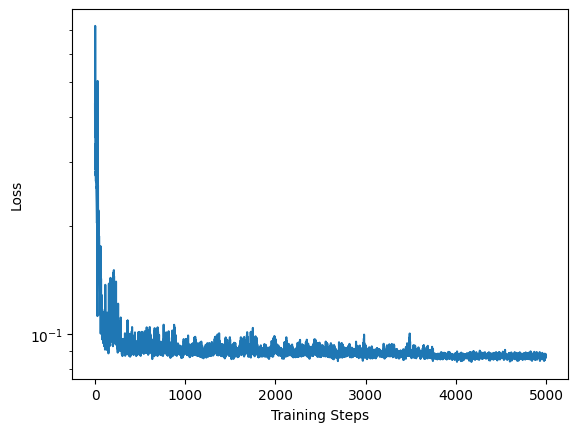

In [12]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [36]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"].permute([0, 3, 1, 2])
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        sample = my_net(image=input_image, epsilon=torch.randn_like(target_fluxes), is_training=False)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

100%|██████████| 5000/5000 [00:26<00:00, 188.57it/s]


In [37]:
val_true_fluxes = val_true_fluxes.cpu()

In [38]:
val_true_fluxes.shape

torch.Size([30000, 1])

In [39]:
val_est_fluxes.shape

torch.Size([5000, 30000, 1])

In [40]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(2165.5273)

In [41]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(35.4712)

In [42]:
# plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True, label="Est")
# plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True, label="True")
# plt.ylabel("Density")
# plt.xlabel("Flux")
# plt.legend()
# plt.show()

In [43]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])

In [44]:
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [45]:
actual_ci_cover

tensor([0.0503, 0.1001, 0.1481, 0.1985, 0.2471, 0.2966, 0.3450, 0.3952, 0.4435,
        0.4933, 0.5422, 0.5885, 0.6389, 0.6890, 0.7398, 0.7886, 0.8384, 0.8884,
        0.9401])

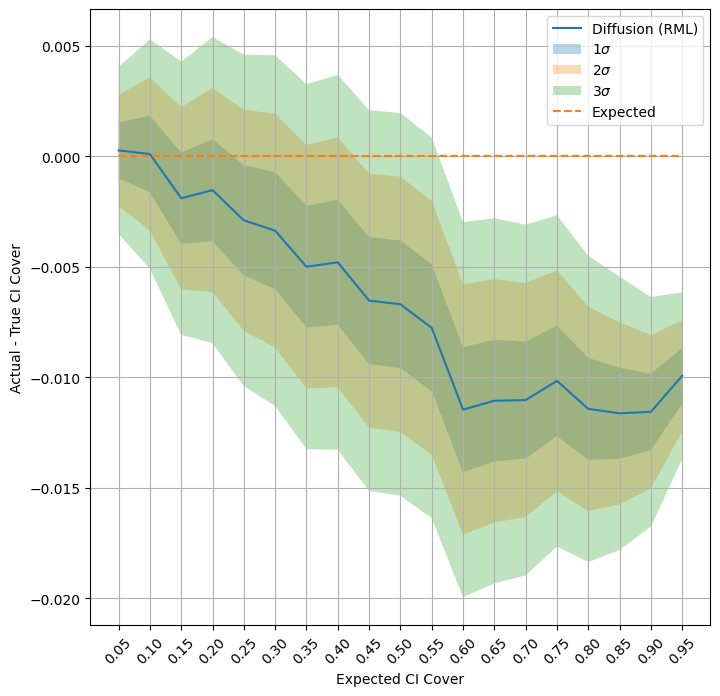

In [46]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="Diffusion (RML)")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [47]:
true_post_dist = image_simulator.post_dist(val_catalog)

In [48]:
true_post_dist

MixtureSameFamily(
  Categorical(probs: torch.Size([30000, 1]), logits: torch.Size([30000, 1])),
  Gamma(concentration: torch.Size([30000, 1]), rate: torch.Size([30000, 1])))

In [49]:
(-1 * true_post_dist.log_prob(val_est_fluxes.squeeze(-1))).mean()

tensor(4.8806, device='cuda:3')

In [50]:
(-1 * true_post_dist.log_prob(true_post_dist.sample((val_iters, )))).mean()

tensor(4.8424, device='cuda:3')

In [51]:
def wasserstein_distance(est_samples: torch.Tensor, true_samples: torch.Tensor):
    assert est_samples.ndim == 2  # (val_iters, val_batch_size)
    assert est_samples.shape == true_samples.shape
    sorted_true_samples = torch.sort(true_samples, dim=0, descending=False)[0]
    sorted_est_samples = torch.sort(est_samples, dim=0, descending=False)[0]
    return torch.abs(sorted_est_samples - sorted_true_samples).mean(dim=0)  # (b, )

In [61]:
wasserstein_distance(val_est_fluxes.squeeze(-1), true_post_dist.sample((val_iters, )).cpu()).mean()

tensor(1.9617)

In [53]:
val_true_fluxes[0]

tensor([440.4596])

In [54]:
val_est_fluxes.shape

torch.Size([5000, 30000, 1])

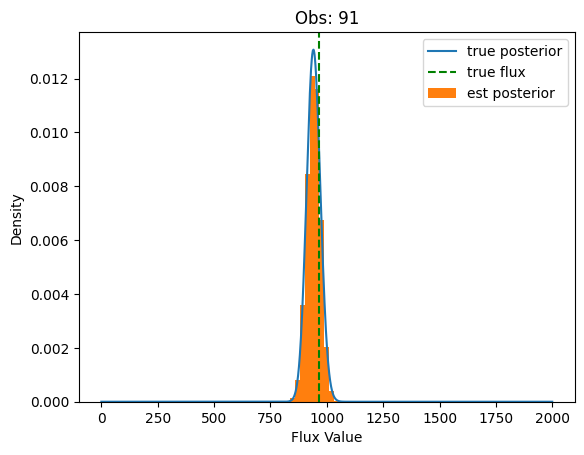

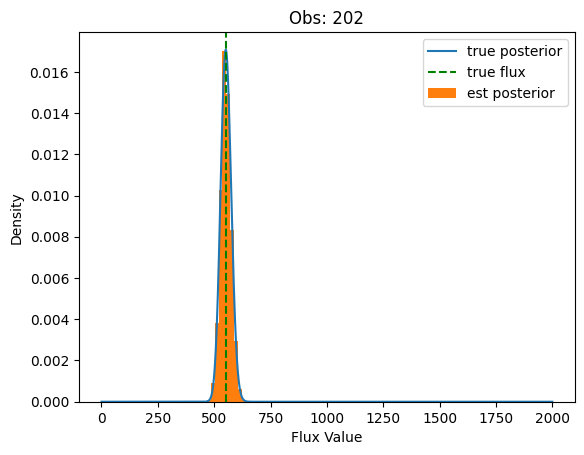

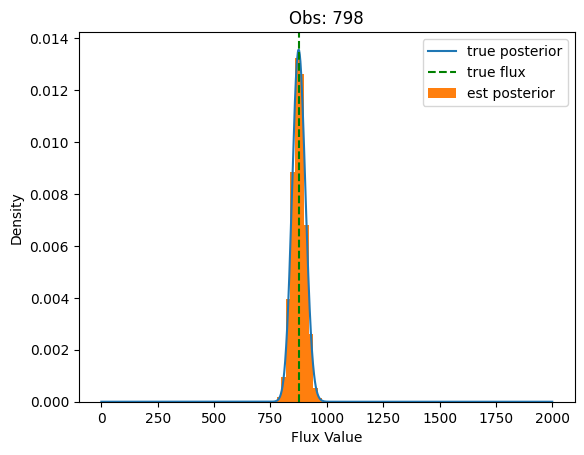

In [55]:
x = torch.linspace(0, 2000, 5000)
obs_index = [91, 202, 798]
for i in obs_index:
    plt.plot(x, true_post_dist.log_prob(x.view(-1, 1))[:, i].exp().cpu(), label="true posterior")
    plt.axvline(x=val_true_fluxes[i].item(), color="green", linestyle="dashed", label="true flux")
    plt.hist(val_est_fluxes[:, i, 0].cpu(), density=True, bins=10, label="est posterior")
    plt.legend()
    plt.xlabel("Flux Value")
    plt.ylabel("Density")
    plt.title(f"Obs: {i}")
    plt.show()